In [1]:
# Cell 1: Install Dependencies (if needed)
!pip install pandas numpy sentence-transformers scikit-learn spacy seaborn matplotlib plotly textblob
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 114.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Cell 2: Imports & Configuration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import plotly.express as px

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Load Spacy
nlp = spacy.load("en_core_web_sm")

# Basic Quantitative Baselines

In [4]:
# Cell 3: Load Data & Preprocessing
# Replace 'merged_data.json' with your actual file path
df = pd.read_json("/content/combined_unified_absa.json")

# 1. Normalize Boolean Fields (Ensure they are real Bools, not Strings)
bool_cols = ['is_implicit', 'has_slang', 'has_emoji']
for col in bool_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.upper() == 'TRUE'

# 2. Basic Tokenization for Length Checks
df['tokens'] = df['text'].apply(lambda x: x.split())
df['token_count'] = df['tokens'].apply(len)

print(f"Total Samples (Rows): {len(df)}")
print(f"Unique Texts (Sentences): {df['id'].nunique()}")
print(df.head(2))

Total Samples (Rows): 3935
Unique Texts (Sentences): 3019
   id                                               text     aspect_term  \
0   1  This new phone is... a choice. The screen is a...  screen_quality   
1   1  This new phone is... a choice. The screen is a...    battery_life   

      span_text sentiment                                          rationale  \
0        screen  positive  Explicit: 'screen is amazing' is clear positiv...   
1  battery dies  negative  Implicit: 'battery dies in 3 hours' is evidenc...   

   is_implicit  has_slang  has_emoji  \
0        False      False      False   
1         True      False      False   

                                              tokens  token_count  
0  [This, new, phone, is..., a, choice., The, scr...           27  
1  [This, new, phone, is..., a, choice., The, scr...           27  


Avg Aspects per Sentence: 1.30
Max Aspects in Single Text: 13
Avg Token Length: 21.1
P95 Length (Truncation Limit): 56.29999999999973
Implicitness Ratio: 59.47% (Target: >25% for high difficulty)

Sentiment Distribution:
sentiment
negative    0.626938
positive    0.322490
neutral     0.050572
Name: proportion, dtype: float64


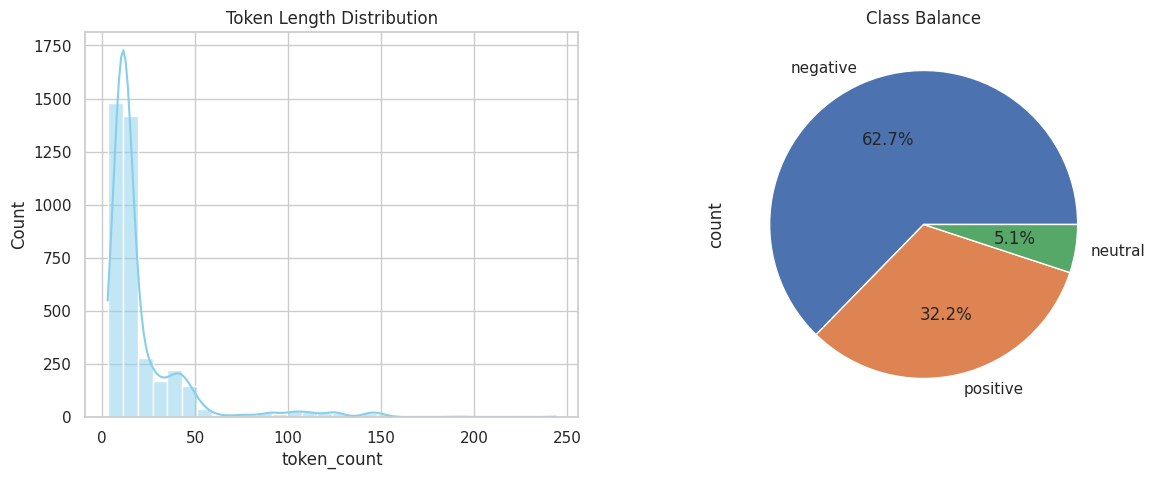

In [5]:
# A. Multi-Aspect Density (How many aspects per sentence ID?)
aspects_per_text = df.groupby('id').size()
print(f"Avg Aspects per Sentence: {aspects_per_text.mean():.2f}")
print(f"Max Aspects in Single Text: {aspects_per_text.max()}")

# B. Length Profile
print(f"Avg Token Length: {df['token_count'].mean():.1f}")
print(f"P95 Length (Truncation Limit): {df['token_count'].quantile(0.95)}")

# C. Implicitness Ratio (Core Research Metric)
implicit_ratio = df['is_implicit'].mean()
print(f"Implicitness Ratio: {implicit_ratio*100:.2f}% (Target: >25% for high difficulty)")

# D. Class Balance
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts(normalize=True))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['token_count'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title("Token Length Distribution")
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
ax[1].set_title("Class Balance")
plt.show()

In [7]:
def get_pos_counts(text):
    doc = nlp(text)
    counts = Counter([token.pos_ for token in doc])
    return {
        'NOUN': counts.get('NOUN', 0),
        'ADJ': counts.get('ADJ', 0),
        'VERB': counts.get('VERB', 0),
        'ADV': counts.get('ADV', 0)
    }

# Run on sample (or full dataset if <5k rows)
# Using head(500) for speed in demo
pos_df = df['text'].head(500).apply(get_pos_counts).apply(pd.Series)
pos_ratios = pos_df.mean()

print("--- Standard Linguistic Profile ---")
print(f"Avg Nouns per text: {pos_ratios['NOUN']:.1f}")
print(f"Avg Adjectives per text: {pos_ratios['ADJ']:.1f}")
print(f"Adjective/Noun Ratio: {pos_ratios['ADJ'] / pos_ratios['NOUN']:.2f}")
# Research Note: Higher ratio (>0.5) confirms subjective opinionated text.

--- Standard Linguistic Profile ---
Avg Nouns per text: 2.9
Avg Adjectives per text: 1.4
Adjective/Noun Ratio: 0.49


--- Aspect Sentiment Entropy (Top 5 Hardest) ---
aspect_term
atmosphere       1.061208
sound_quality    1.024010
plot             0.934770
performance      0.882631
portion_size     0.855613
Name: sentiment, dtype: float64

(Higher Entropy = More Balanced/Difficult. Zero = Bias)


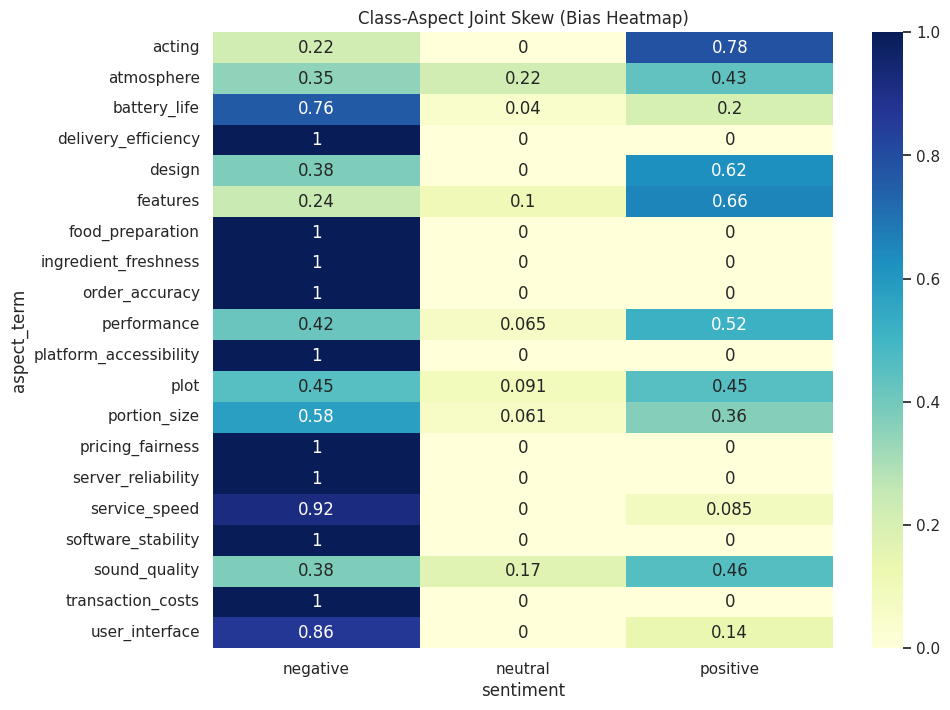

In [9]:
from scipy.stats import entropy
def calculate_entropy(series):
    counts = series.value_counts(normalize=True, sort=False)
    return entropy(counts)

# Calculate entropy for top 20 aspects
top_aspects = df['aspect_term'].value_counts().head(20).index
entropy_scores = df[df['aspect_term'].isin(top_aspects)].groupby('aspect_term')['sentiment'].apply(calculate_entropy)

print("--- Aspect Sentiment Entropy (Top 5 Hardest) ---")
print(entropy_scores.sort_values(ascending=False).head(5))
print("\n(Higher Entropy = More Balanced/Difficult. Zero = Bias)")

# Visualization: Skew Heatmap
skew_matrix = pd.crosstab(df[df['aspect_term'].isin(top_aspects)]['aspect_term'], df['sentiment'], normalize='index')
plt.figure(figsize=(10, 8))
sns.heatmap(skew_matrix, annot=True, cmap="YlGnBu")
plt.title("Class-Aspect Joint Skew (Bias Heatmap)")
plt.show()

# Quantitative Baselines (The "What")

Avg Aspects per Text: 1.30
Max Aspects in one Text: 13
Token Length P50 (Median): 12.0
Token Length P95 (Truncation Risk): 56.29999999999973
Total Unique Aspects: 1495
Rare Aspects (<5 samples): 1389


/tmp/ipython-input-3391085994.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")


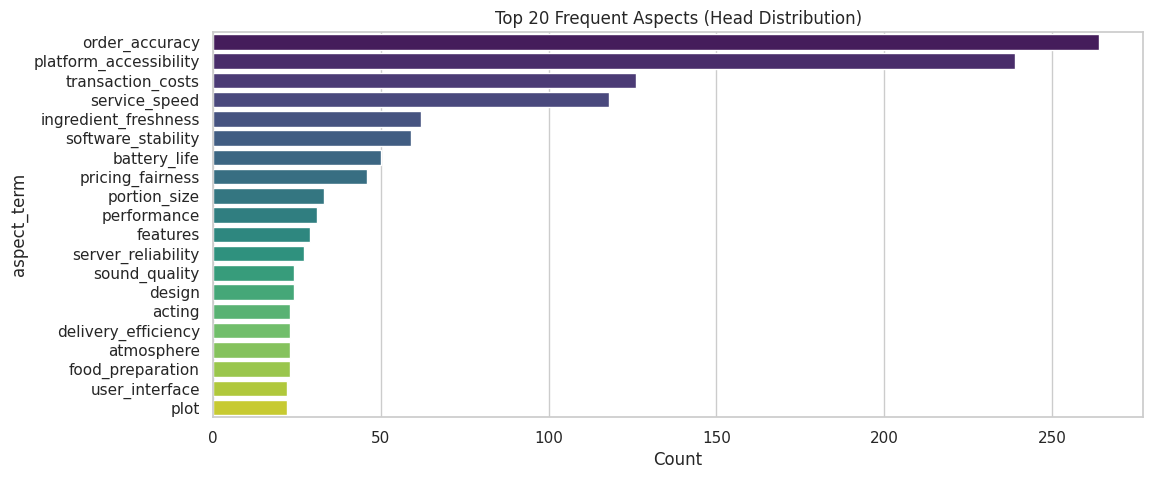

/tmp/ipython-input-3391085994.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, ax=axes[1], palette="coolwarm")


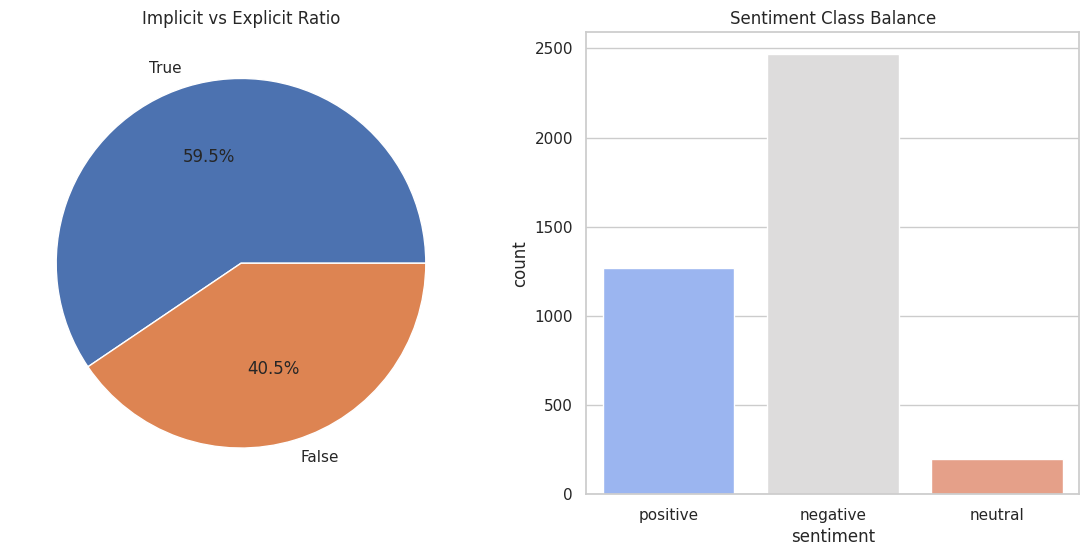

In [5]:
# Cell 4: Structural & Distribution Metrics

# --- A. Multi-Aspect Intensity ---
# Group by ID to see how many aspects per single text
aspects_per_text = df.groupby('id').size()
print(f"Avg Aspects per Text: {aspects_per_text.mean():.2f}")
print(f"Max Aspects in one Text: {aspects_per_text.max()}")

# --- B. Length Profile (P50/P95) ---
p50 = df['token_count'].median()
p95 = df['token_count'].quantile(0.95)
print(f"Token Length P50 (Median): {p50}")
print(f"Token Length P95 (Truncation Risk): {p95}")

# --- C. Aspect Head vs. Tail ---
top_20 = df['aspect_term'].value_counts().head(20)
tail_aspects = df['aspect_term'].value_counts()[df['aspect_term'].value_counts() < 5]
print(f"Total Unique Aspects: {df['aspect_term'].nunique()}")
print(f"Rare Aspects (<5 samples): {len(tail_aspects)}")

# Visualization
plt.figure(figsize=(12, 5))
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")
plt.title("Top 20 Frequent Aspects (Head Distribution)")
plt.xlabel("Count")
plt.show()

# --- D. Implicitness & Sentiment Ratio ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Implicit Pie Chart
df['is_implicit'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0], title="Implicit vs Explicit Ratio")
axes[0].set_ylabel('')

# Sentiment Bar Chart
sns.countplot(x='sentiment', data=df, ax=axes[1], palette="coolwarm")
axes[1].set_title("Sentiment Class Balance")
plt.show()

# Linguistic Complexity (The "Texture")

In [6]:
# Cell 5: Linguistic Complexity Analysis

# --- A. OOV / Rare Token Rate ---
# Flatten all tokens to build a vocab
all_tokens = [token for sublist in df['tokens'] for token in sublist]
vocab_counts = Counter(all_tokens)
rare_tokens = {word for word, count in vocab_counts.items() if count < 5}

total_tokens = len(all_tokens)
rare_token_count = sum(vocab_counts[t] for t in rare_tokens)
print(f"Vocabulary Size: {len(vocab_counts)}")
print(f"Rare Token Rate (Sparsity): {(rare_token_count/total_tokens)*100:.2f}%")

# --- B. Lexical Diversity (TTR) ---
ttr = len(vocab_counts) / total_tokens
print(f"Type-Token Ratio (TTR): {ttr:.4f}")
# Note: Higher TTR = richer vocabulary (typical of open-domain social text)

# --- C. Syntactic Complexity (Tree Depth) ---
# This takes a minute. We calculate the depth of the dependency tree.
def get_tree_depth(doc):
    depths = {}
    for token in doc:
        d = 0
        head = token
        while head.head != head:
            head = head.head
            d += 1
        depths[token] = d
    return max(depths.values()) if depths else 0

# Sample 500 texts for speed (or run on all if you have time)
sample_docs = list(nlp.pipe(df['text'].head(500).astype(str)))
avg_depth = np.mean([get_tree_depth(doc) for doc in sample_docs])
print(f"Avg Syntactic Tree Depth: {avg_depth:.2f} (Higher = More Complex Sentence Structure)")

Vocabulary Size: 12983
Rare Token Rate (Sparsity): 19.49%
Type-Token Ratio (TTR): 0.1565
Avg Syntactic Tree Depth: 2.97 (Higher = More Complex Sentence Structure)


# Deep Semantic Analysis (The "Why")

In [10]:
# Cell 6: Generate Embeddings (The Heavy Lifting)
# Load a high-quality teacher model
model = SentenceTransformer('all-mpnet-base-v2')

print("Encoding Text...")
text_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

print("Encoding Aspects...")
aspect_embeddings = model.encode(df['aspect_term'].tolist(), show_progress_bar=True)

print("Encoding Rationales...")
rationale_embeddings = model.encode(df['rationale'].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding Text...


Batches:   0%|          | 0/123 [00:00<?, ?it/s]

Encoding Aspects...


Batches:   0%|          | 0/123 [00:00<?, ?it/s]

Encoding Rationales...


Batches:   0%|          | 0/123 [00:00<?, ?it/s]

In [11]:
# Cell 7: Semantic Validation Metrics

# --- A. Implicit "Hardness" Gap ---
# Cosine Sim between Text and Aspect
# Explicit samples should be CLOSE (High Sim), Implicit should be FAR (Low Sim)
sim_text_aspect = np.diag(cosine_similarity(text_embeddings, aspect_embeddings))
df['semantic_gap'] = 1 - sim_text_aspect

print("Implicit Hardness Gap (1 - Similarity):")
print(df.groupby('is_implicit')['semantic_gap'].mean())
# Ideally: True > False

# --- B. Aspect-Rationale Alignment (ARAS) ---
# Does the rationale actually explain the aspect?
sim_aspect_rationale = np.diag(cosine_similarity(aspect_embeddings, rationale_embeddings))
df['aras_score'] = sim_aspect_rationale
print(f"\nAvg Aspect-Rationale Alignment: {df['aras_score'].mean():.4f}")

# --- C. Cluster Purity / NMI ---
# Can K-Means find your aspects purely from the text vectors?
n_aspects = df['aspect_term'].nunique()
kmeans = KMeans(n_clusters=n_aspects, random_state=42, n_init=10).fit(text_embeddings)
nmi_score = normalized_mutual_info_score(df['aspect_term'], kmeans.labels_)
print(f"\nAspect Separability (NMI Score): {nmi_score:.4f}")
# Higher NMI = Your aspects are distinct concepts, not random noise.

# --- D. Aspect Semantic Separability (Silhouette) ---
# How distinct are the aspect terms themselves?
# We cluster the UNIQUE aspect terms
unique_aspects = df['aspect_term'].unique()
unique_aspect_embeds = model.encode(unique_aspects)
# Note: Silhouette requires > 1 cluster and > 1 sample.
# We estimate K roughly as sqrt(N/2) or just use K=5 broad domains
k_broad = 5
kmeans_aspects = KMeans(n_clusters=k_broad, random_state=42, n_init=10).fit(unique_aspect_embeds)
sil_score = silhouette_score(unique_aspect_embeds, kmeans_aspects.labels_)
print(f"Aspect Silhouette Score (Semantic Distinctness): {sil_score:.4f}")

Implicit Hardness Gap (1 - Similarity):
is_implicit
False    0.688598
True     0.798048
Name: semantic_gap, dtype: float32

Avg Aspect-Rationale Alignment: 0.4674

Aspect Separability (NMI Score): 0.7771
Aspect Silhouette Score (Semantic Distinctness): 0.0248


In [12]:
# Cosine Sim between Aspect and Rationale
# Does the rationale explain the *specific* aspect?
aras_scores = np.diag(cosine_similarity(aspect_embeddings, rationale_embeddings))
df['aras'] = aras_scores

print(f"Avg Aspect-Rationale Alignment Score (ARAS): {df['aras'].mean():.4f}")
# Filter: If ARAS < 0.2, the rationale might be hallucinated or generic.
print(f"Potential Rationale Hallucinations (<0.2): {sum(df['aras'] < 0.2)}")

Avg Aspect-Rationale Alignment Score (ARAS): 0.4674
Potential Rationale Hallucinations (<0.2): 154


# Bias & Consistency (The "Integrity")

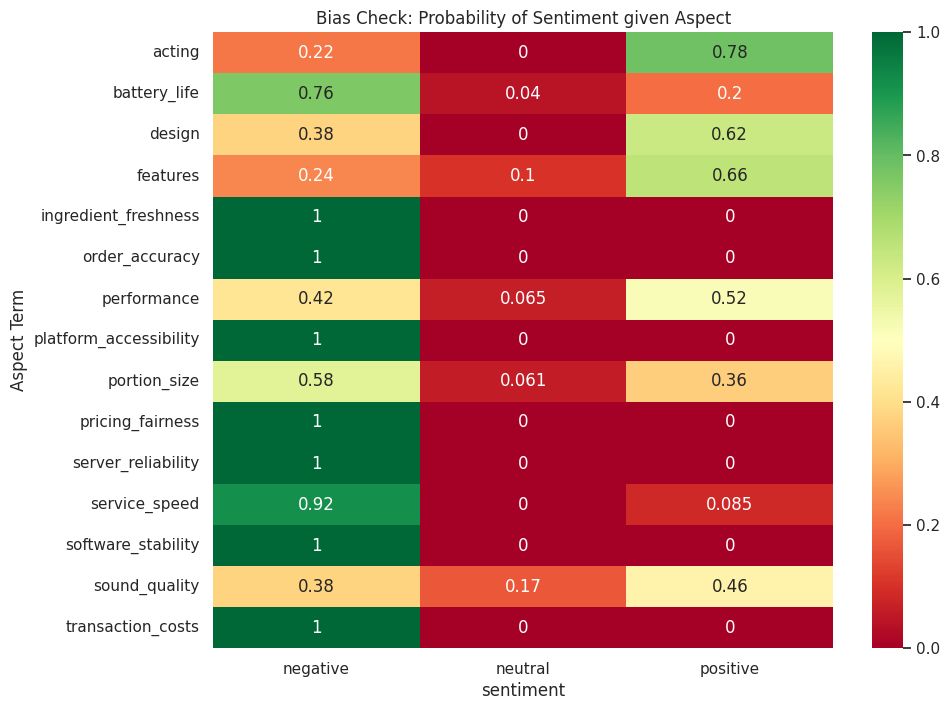

Avg Polarity Drift (Label Noise): 0.4981


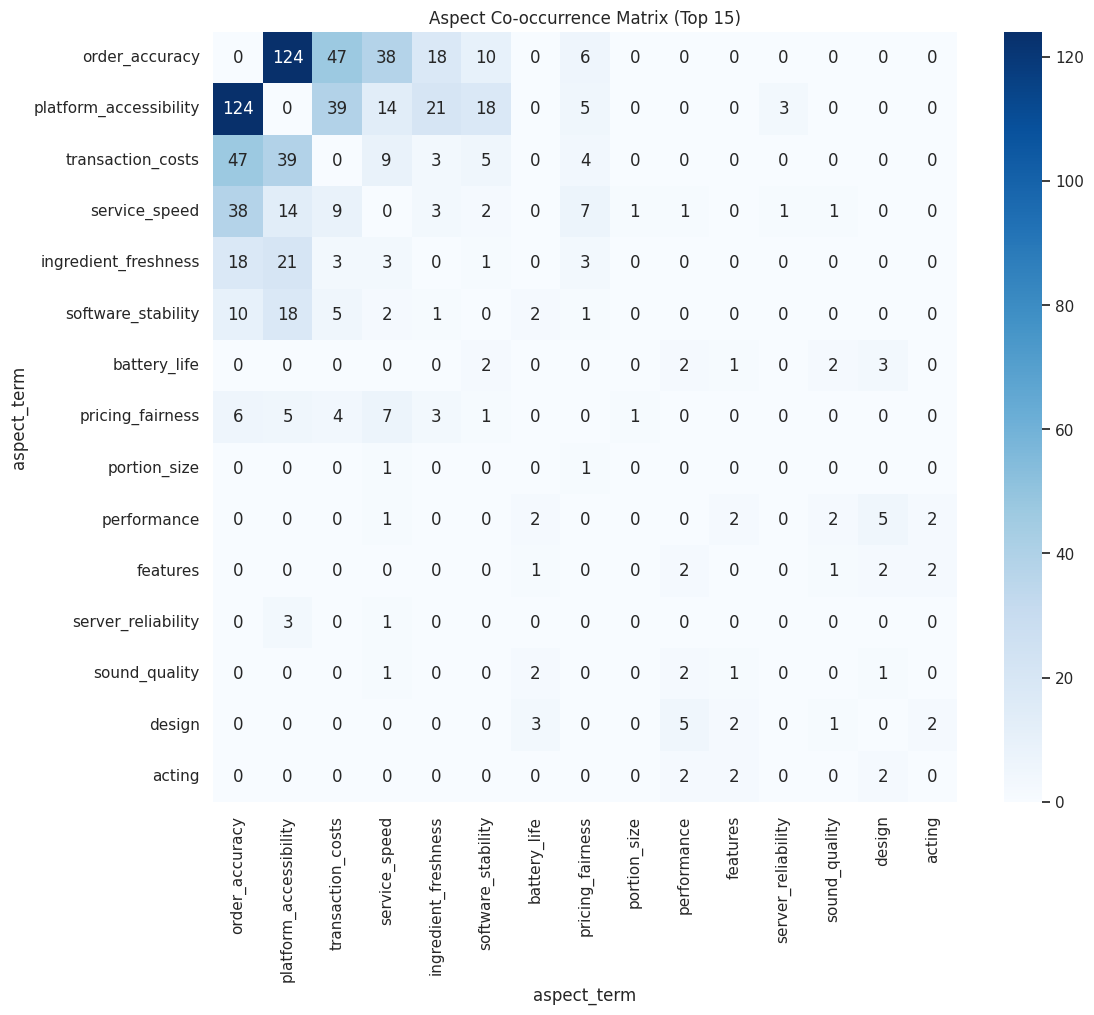

In [13]:
# Cell 8: Bias and Label Consistency

# --- A. Class-Aspect Joint Skew (Heatmap) ---
# Filter for top 15 aspects to make the heatmap readable
top_15_aspects = df['aspect_term'].value_counts().head(15).index
skew_df = df[df['aspect_term'].isin(top_15_aspects)]

skew_matrix = pd.crosstab(skew_df['aspect_term'], skew_df['sentiment'], normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(skew_matrix, annot=True, cmap='RdYlGn', center=0.5)
plt.title("Bias Check: Probability of Sentiment given Aspect")
plt.ylabel("Aspect Term")
plt.show()

# --- B. Sentiment Polarity Drift (Annotation Consistency) ---
# Check if semantically similar texts have the same sentiment
# 1. Convert sentiments to numbers
sent_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sent_val'] = df['sentiment'].map(sent_map).fillna(0) # handle missing/typos

# 2. Find 5 nearest neighbors for every text
nbrs = NearestNeighbors(n_neighbors=6, metric='cosine').fit(text_embeddings)
distances, indices = nbrs.kneighbors(text_embeddings)

# 3. Calculate variance of sentiment among neighbors
drift_scores = []
for idx_list in indices:
    # idx_list[0] is self, 1-5 are neighbors
    neighbor_sents = df.iloc[idx_list[1:]]['sent_val'].values
    drift_scores.append(np.std(neighbor_sents))

df['polarity_drift'] = drift_scores
print(f"Avg Polarity Drift (Label Noise): {np.mean(drift_scores):.4f}")
# High drift (> 0.5) implies your annotations are inconsistent for similar texts.

# --- C. Aspect Co-occurrence (Entanglement) ---
# Which aspects appear together?
# Create a matrix of IDs x Aspects
basket = df.groupby(['id', 'aspect_term']).size().unstack(fill_value=0)
basket[basket > 0] = 1 # Binarize
co_occurrence = basket.T.dot(basket)
np.fill_diagonal(co_occurrence.values, 0) # Remove self-loops

# Plot top interactions
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence.loc[top_15_aspects, top_15_aspects], annot=True, cmap="Blues", fmt="d")
plt.title("Aspect Co-occurrence Matrix (Top 15)")
plt.show()

# Visualization (The "Proof")

In [14]:
# Cell 9: Latent Space Visualization
from sklearn.manifold import TSNE

# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(text_embeddings)

df['x'] = vis_dims[:, 0]
df['y'] = vis_dims[:, 1]

# Plot only Top 10 aspects to avoid clutter
top_10 = df['aspect_term'].value_counts().head(10).index
subset = df[df['aspect_term'].isin(top_10)]

fig = px.scatter(
    subset, x='x', y='y',
    color='aspect_term', symbol='is_implicit',
    hover_data=['text', 'rationale'],
    title="t-SNE of Semantic Space (Top 10 Aspects)",
    template="plotly_white"
)
fig.show()